# Нейронная сеть для предсказания выживаемости на Титанике

В предыдущей работе был проведён разведочный анализ данных (EDA), в результате которого был исследован исходный датасет о пассажирах "Титаника", были выяснены основные факторы выживаемости на "Титанике", были выделены благополучные и уязвимые группы людей, а также выделены были признаки, по которым лучше всего тренировать нейросеть для предсказания выживаемости. Напомним основные выводы:

Ключевые закономерности:

- Женщины выживали в 4 раза чаще мужчин.

- 1-й класс имел преимущество в спасении, по сравнению со 2 и 3 классами.

- Небольшие семьи (1-4 человека) выживали чаще одиночек и больших семей.

- Дорогие билеты коррелируют с выживаемостью (косвенно через класс), повышая шанс на выживаемость.

Перспективные признаки для ML:

`Sex`, `Pclass`, `Fare`, `FamilySize`, `Title` (который извлекается из имени)

Уязвимые группы:

- Мужчины 3-го класса, путешествующие в одиночку, имели наихудшие шансы (выжило <15%).

Признаки `FamilySize`, `Title` являются составными, проще говоря, в предыдущей работе мы их сами собрали, и так как они показали наибольшую корреляцию, мы их снова соберём в этой работе.

Такая техника называется feature engineering (конструирование признаков) - это метод, позволяющий составлять новые признаки из уже имеющихся в рассматриваемой области. Далее эти признаки будут использоваться моделю для наиболее качественных (верных) предсказаний.

## Общее описание работы

Данная работа направлена на создание нейронной сети для предсказания выживаемости пассажиров Титаника. Работа разделяется на этапы:
1. Загрузка библиотек и инициализация данных
2. Предобработка данных
  - Заполнение пропусков.
  - Преобразование категориальных признаков в числовые.
  - Масштабирование данных.
  - Разделение на обучающую и тестовую выборки.
3. Создание, настройка и обучение модели нейронной сети и её тестирование
4. Визуализация результатов
5. Заключение

# Загрузка библиотек

Установим следующие библиотеки:

**numpy** - модуль для научных вычислений, работы с многомерными массивами и линейной алгебры.

**pandas** - библиотека для анализа и обработки табличных данных.

**os** - модуль для взаимодействия с операционной системой (работа с путями файлов).

**tree** - содержит алгоритмы деревьев решений.

**matplotlib.pyplot** - библиотека для визуализации данных и построения графиков.

**seaborn** - библиотека для статистической визуализации на основе matplotlib.

**IPython.display** - инструменты для интерактивного отображения объектов в Jupyter.

**train_test_split** - функция для разделения данных на обучающую и тестовую выборки.

**StandardScaler** - инструмент для стандартизации признаков.

**Sequential**, **Dense**, **Dropout**, **Input** (из **keras.models** и **keras.layers**) - компоненты для построения нейронных сетей.

**LabelEncoder** - кодирование категориальных признаков в числовые.

**to_categorical** - преобразование меток в one-hot кодирование.

Специальная команда Jupyter:

**%matplotlib inline** - магическая команда для отображения графиков непосредственно в ноутбуке.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

%matplotlib inline

# Инициализация данных

Загружаем датасет "Титаник" из CSV файла в переменную *df*:

In [2]:
df = pd.read_csv("Titanic.csv")

Далее добавим признаки `FamilySize` (размер семьи), `Title` (обращение или титул). Дополнительно создадим ещё 2 признака: `AgeGroup` - возратсная группа и `IsAlone` - люди-одиночки:

In [3]:
# Извлекаем титулы из имен
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Группировка редких титулов
df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don',
                                   'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')

# Создаем признак размера семьи (на основе EDA)
df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

# Создаем признак возрастной группы (на основе EDA)
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 60, 100],
                        labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

# Предобработка данных

Предобработка данных или подготовка предварительных данных (Data Preprocessing) — этап подготовки "сырых" данных к анализу и машинному обучению. К примеру, заполнение пропущенных значений некоторыми усреднёнными по заполняемой категории, очистка от шумов и аномальных данных, масштабирование или стандартизация (сведение всех числовых данных к некоторому диапозону) и т.п.

## Заполнение пропусков

Выведем количество пропущенных значений для каждого столбца:

In [4]:
print("Пропуски до обработки:")
display(df.isna().sum())

Пропуски до обработки:


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Мы обрабатываем пропущенные значения следующим образом:
1. Возраст заполняем медианой, или средним значением.
2. Порт посадки заполняется самым частым значением по моде.

Также стоит отметить, что мы не заполняем столбец кают (Cabin) в виду того, что у нас слишком мало данных о нём, и мы можем заполнить этот столбец ненадёжными значениями.

In [5]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

Выведем дата-фрейм после заполнения:

In [6]:
print("Пропуски после обработки:")
display(df.isna().sum())

Пропуски после обработки:


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


Отбросим ненужные столбцы (было поулчено из EDA):

In [7]:
df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

## Преобразование категориальных признаков в числовые

Выведем все доступные столбцы в *df*:

In [8]:
print(df.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'FamilySize', 'IsAlone', 'AgeGroup'],
      dtype='object')


Категориальные признаки необходимо преобразовать в числовой формат для использования в нейронной сети. Мы используем *LabelEncoding* — метод, присваивающий каждому уникальному значению целое число.

В данном случае мы сделаем следующие преобразования:

Для признака `Sex`:
- "male" = 0.
- "female" = 1.

Для признака `Embarked`
- "S" = 0.
- "C" = 1.
- "Q" = 2.

Для признака  `Title`:
- "Mr" = 0.
- "Miss" = 1.
- "Mrs" = 2.
- ...

In [9]:
# Список категориальных признаков для кодирования
categorical_features = ['Sex', 'Embarked', 'Title', 'AgeGroup']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

# Удаляем нефункциональные столбцы
#df.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis=1, inplace=True)

## Масштабирование данных

Разделяем данные:

- X (признаки): это все столбцы, кроме целевого (Survived).

- y (целевая переменная): это только столбец Survived, то есть то, что будет предсказывать модель.

Стандартизация данных с помощью **StandardScaler**, работащий по следующей формуле:

$$z = \frac{x - \mu}{\sigma}$$

Где:
- $z$: стандартизированное значение признака.

- $x$: исходное значение признака.

- $\mu$: среднее арифметическое признака (рассчитанное по обучающей выборке).

- $\sigma$: стандартное отклонение признака (рассчитанное по обучающей выборке).

После стандартизации все признаки имеют $\mu = 0$, $\sigma = 1$ .

Преобразование в массивы:
- Конвертируем данные в numpy.ndarray для совместимости с Keras/TensorFlow.

In [10]:
# Разделение на признаки и целевую переменную
X = df.drop('Survived', axis=1)  # Все столбцы, кроме 'Survived'
y = df['Survived']               # Целевая переменная

# Масштабирование признаков
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Преобразование в массивы numpy
X = np.array(X)
y = np.array(y)

## Формирование тренировочной и тестирующей выборок

Разделяем данные на обучающую и тестовую выборки в соотношении 80:20 (80% для обучения, 20% для тестирования):

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

Преобразуем метки в нужный формат для того, чтобы их смогла использовать нейросеть:

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Создание и обучение нейронной сети

Перечислим основные этапы работы.

## Настройка кросс-валидации

Мы используем 5-кратную кросс-валидацию с перемешиванием для объективной оценки модели:

- Исходные данные разделяются на 5 равных частей (фолдов).

На каждой итерации:

- 4 фолда объединяются в обучающую выборку

- 1 фолд используется как валидационная выборка

Процесс повторяется 5 раз, каждый раз с новой комбинацией фолдов

Это даёт некоторые преимущества:

- Снижает зависимость результатов от конкретного разбиения данных

- Дает статистически значимую оценку качества модели

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=50)

## Защита от переобучения

Механизм "EarlyStopping" (ранней остановки) предотвращает переобучение:

In [14]:
early_stop = EarlyStopping(
    monitor='val_loss',  # Мониторим потери на валидации
    patience=10,         # Ждем 10 эпох без улучшений
    restore_best_weights=True,  # Возвращаем лучшие веса
    verbose=1
)

Принцип работы:

- После каждой эпохи проверяет значение *val_loss*.

- Если улучшения нет 10 эпох подряд - останавливает обучение.

- Восстанавливает веса из лучшей эпохи.

## Создание массивов для сохранения результатов обучения

Для комплексного анализа создаем специальные массивы:

all_reports: отчеты классификации (precision, recall, f1-score)

all_conf_matrices: матрицы ошибок (TP, FP, TN, FN)

val_accuracies: динамика точности на валидации по эпохам

val_losses: динамика потерь на валидации по эпохам

train_accuracies: динамика точности на обучении

train_losses: динамика потерь на обучении

In [15]:
# Даём классам имена
target_names = ['Погиб', 'Выжил']

# Массивы для хранения результатов
all_reports = []
all_conf_matrices = []
val_accuracies = []
val_losses = []
train_accuracies = []
train_losses = []

## Инициализация, обучение и тестирование

В цикле будем каждый раз объявлять модель и обучать, а затем делать предсказания на ней. Сделано это для того, чтобы мы могли проанализировать её результаты на каждом фолде. Все технические моменты будут обхяснены после кода.

In [16]:
for train_idx, val_idx in kf.split(X):
    # Разделение данных
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    # Преобразование меток в one-hot формат для подачи в нейросеть
    y_train_fold = to_categorical(y_train_fold)
    y_val_fold = to_categorical(y_val_fold)

    # Создание модели
    model = Sequential([
        Input(shape=(X_train.shape[1],), name="input_layer"),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')
    ])

    # Компиляция
    model.compile(
    loss='categorical_crossentropy',  # Функция потерь для классификации
    optimizer='adam',                 # Адаптивный оптимизатор
    metrics=['accuracy']              # Метрика качества
    )

    # Обучение
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=80,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    # Сохранение метрик
    train_accuracies.append(history.history['accuracy'])
    train_losses.append(history.history['loss'])
    val_accuracies.append(history.history['val_accuracy'])
    val_losses.append(history.history['val_loss'])

    # Предсказания и оценка
    y_pred = model.predict(X_val_fold)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val_fold, axis=1)

    # Сохранение отчетов
    report = classification_report(
        y_true_classes,
        y_pred_classes,
        target_names=target_names
    )
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    all_reports.append(report)
    all_conf_matrices.append(conf_matrix)

Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5262 - loss: 0.6871 - val_accuracy: 0.7095 - val_loss: 0.6058
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7689 - loss: 0.5546 - val_accuracy: 0.7542 - val_loss: 0.5476
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7796 - loss: 0.5146 - val_accuracy: 0.8045 - val_loss: 0.5040
Epoch 4/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7568 - loss: 0.5023 - val_accuracy: 0.7933 - val_loss: 0.4792
Epoch 5/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8229 - loss: 0.4366 - val_accuracy: 0.8045 - val_loss: 0.4669
Epoch 6/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8191 - loss: 0.4372 - val_accuracy: 0.8101 - val_loss: 0.4626
Epoch 7/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8268 - loss: 0.4132 - val_accuracy: 0.8212 - val_loss: 0.4544
Epoch 8/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8150 - loss: 0.4420 - val_accuracy: 0.8156 - val_loss

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5630 - loss: 0.7296 - val_accuracy: 0.7022 - val_loss: 0.5955
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7191 - loss: 0.5645 - val_accuracy: 0.7303 - val_loss: 0.5470
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7915 - loss: 0.4751 - val_accuracy: 0.7584 - val_loss: 0.5274
Epoch 4/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7856 - loss: 0.4673 - val_accuracy: 0.7640 - val_loss: 0.5189
Epoch 5/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8069 - loss: 0.4355 - val_accuracy: 0.7584 - val_loss: 0.5198
Epoch 6/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8371 - loss: 0.4179 - val_accuracy: 0.7584 - val_loss: 0.5229
Epoch 7/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8445 - loss: 0.4098 - val_accuracy: 0.7584 - val_loss: 0.5179
Epoch 8/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8139 - loss: 0.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Epoch 1/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6855 - loss: 0.6535 - val_accuracy: 0.7416 - val_loss: 0.5515
Epoch 2/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7625 - loss: 0.5441 - val_accuracy: 0.7697 - val_loss: 0.4788
Epoch 3/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7958 - loss: 0.4914 - val_accuracy: 0.8202 - val_loss: 0.4377
Epoch 4/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7880 - loss: 0.4598 - val_accuracy: 0.8427 - val_loss: 0.4190
Epoch 5/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7998 - loss: 0.4862 - val_accuracy: 0.8371 - val_loss: 0.4128
Epoch 6/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8081 - loss: 0.4114 - val_accuracy: 0.8596 - val_loss: 0.4096
Epoch 7/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8154 - loss: 0.4395 - val_accuracy: 0.8539 - val_loss: 0.4104
Epoch 8/80
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8362 - loss: 0.

In [17]:
print(X_train.shape[1])

11


Поясним слои в нейронной сети.

1. Входной слой:

  - Получает данные с размерностью 11 (равно числу признаков).

  - Не содержит параметров для обучения.

  - Определяет форму входных данных.

2. Скрытый слой (содержит 64 нейронов) с ReLU-активацией:

  - Эта функция активации выглядит следующим образом: ReLU(x) = max(0, x), по сути она возвращает положительное значение, либо 0.

  Преимущества функции заключаются в следующем:

  - Она устраняет проблему затухающих градиентов.

  - Ускоряет сходимость в 6 раз по сравнению с сигмоидой.

3. Слой "отключения" (Dropout):

  - Этот слой необходим для предотвращения переобучения.

  - Он случайным образом отключает (обнуляет) 30% нейронов в нейросети на каждом батче.

4. Дополнительный скрытый слой (32 нейрона).

5. Выходной слой с softmax-активацией:

  - Преобразует выходы в вероятностное распределение при помощи softmax-функции.

  - Функция описывается формулой (для признака i): $$P_i(z) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$.

  - Гарантирует, что сумма всех выходов будет равна 1.

Про настройку обучения:
Функция потерь (categorical_crossentropy):

- Рассчитывает расхождение между предсказанными и истинными распределениями по следующей формуле:

$$L = -\sum_{c=1}^{M} y_{o,c} \log(p_{o,c})$$

Где M - число классов, y - бинарный индикатор, p - предсказанная вероятность.

Характеристики оптимизатора Adam:

- Комбинирует преимущества AdaGrad и RMSProp.

- Автоматически адаптирует скорость обучения.

- Параметры по умолчанию: lr=0.001, β1=0.9, β2=0.999.

Алгоритм обновления весов выглядит следующим образом:

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$

$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$

$$\theta_t = \theta_{t-1} - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

Метрика Accuracy, рассчитывается так:

$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

Обсудим некоторые параметры обучения:

- Epochs=80: Максимальное число эпох (обычно обучение останавливается раньше через EarlyStopping).

- Batch_size=32: Число образцов для одного обновления весов.

Меньшие батчи: более частые обновления, больше шума.

Большие батчи: стабильнее градиенты, но требует больше памяти.

- Validation_data: Валидационный набор для мониторинга переобучения.

- Callbacks: Механизмы обратного вызова (ранняя остановка).

- Verbose=1: вывод информации об обучении.

# Визуализация

## Визуализация данных фолдов

Визуализируем на столбачтой диаграмме следующие характеристики:
1. Accuracy (Точность) — доля верных предсказаний.

2. Precision (Точность класса) — сколько из предсказанных "выживших" действительно выжили.

3. Recall (Полнота) — сколько реальных "выживших" модель обнаружила.

4. F1-Score — среднее гармоническое Precision и Recall (баланс между ними).

Соберём метрики для каждого фолда из результатов обучения:

In [18]:
fold_metrics = []

for i, (report, cm) in enumerate(zip(all_reports, all_conf_matrices)):
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fold_metrics.append({
        'Fold': f'Fold {i+1}',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

Преобразуем данные метрик в дата-фрейм:

In [19]:
metrics_df = pd.DataFrame(fold_metrics)

Далее строим сам график:

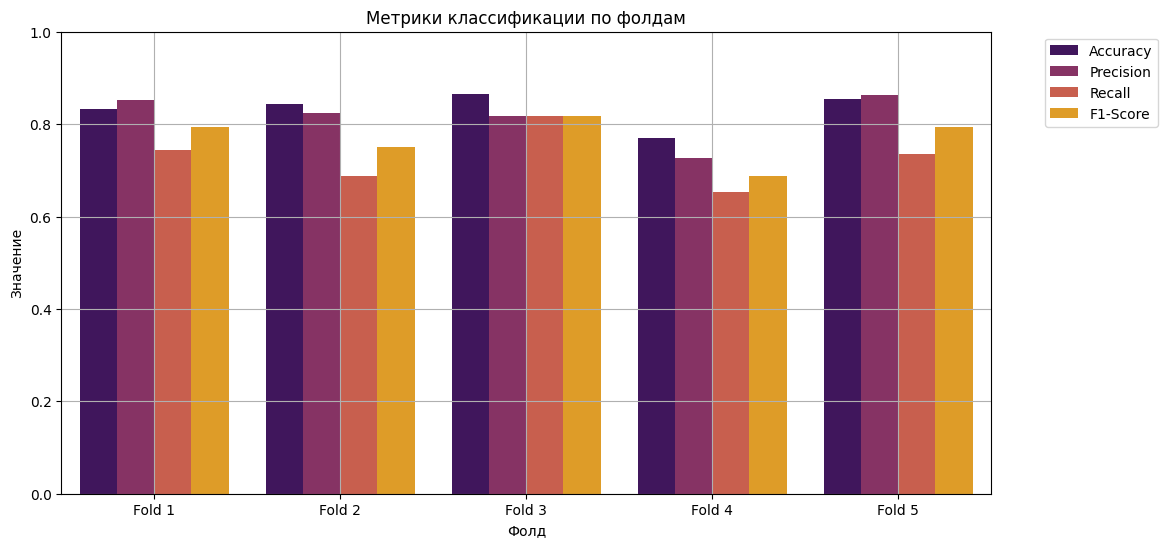

In [20]:
plt.figure(figsize=(12, 6))
sns.barplot(data=pd.melt(metrics_df, id_vars='Fold'), x='Fold', y='value', hue='variable', palette='inferno')
plt.title('Метрики классификации по фолдам')
plt.xlabel('Фолд')
plt.ylabel('Значение')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

### Вывод

После анализа диаграммы сделаем следующие выводы:

- Значения метрики Accuracy на всех фолдах (кроме 4) находятся в пределах 0.8.

- Отсутствие выбросов (все значения группируются вокруг среднего).

>Модель демонстрирует стабильную работу на различных подвыборках данных:
- Нет признаков переобучения.
- Качество предсказаний не зависит от случайного разбиения.
- Обобщающая способность подтверждена на независимых выборках.

## Графики с доверительными интервалами (стандартное отклонение)

На графике можно увидеть следующее:

Сплошная синяя/оранжевая линия:

- Среднее значение метрики по всем доступным фолдам.

- Ширина линии пропорциональна стандартному отклонению.

Закрашенная область:

- Доверительный интервал (±1 стандартное отклонение).

- Показывает вариативность между фолдами.

Красная штриховка (была введена из-за различного количества эпох в каждом фолде):

- Область, где часть фолдов уже остановилась.

- Интенсивность области (закрашенность) показывает, сколько фолдов осталось.

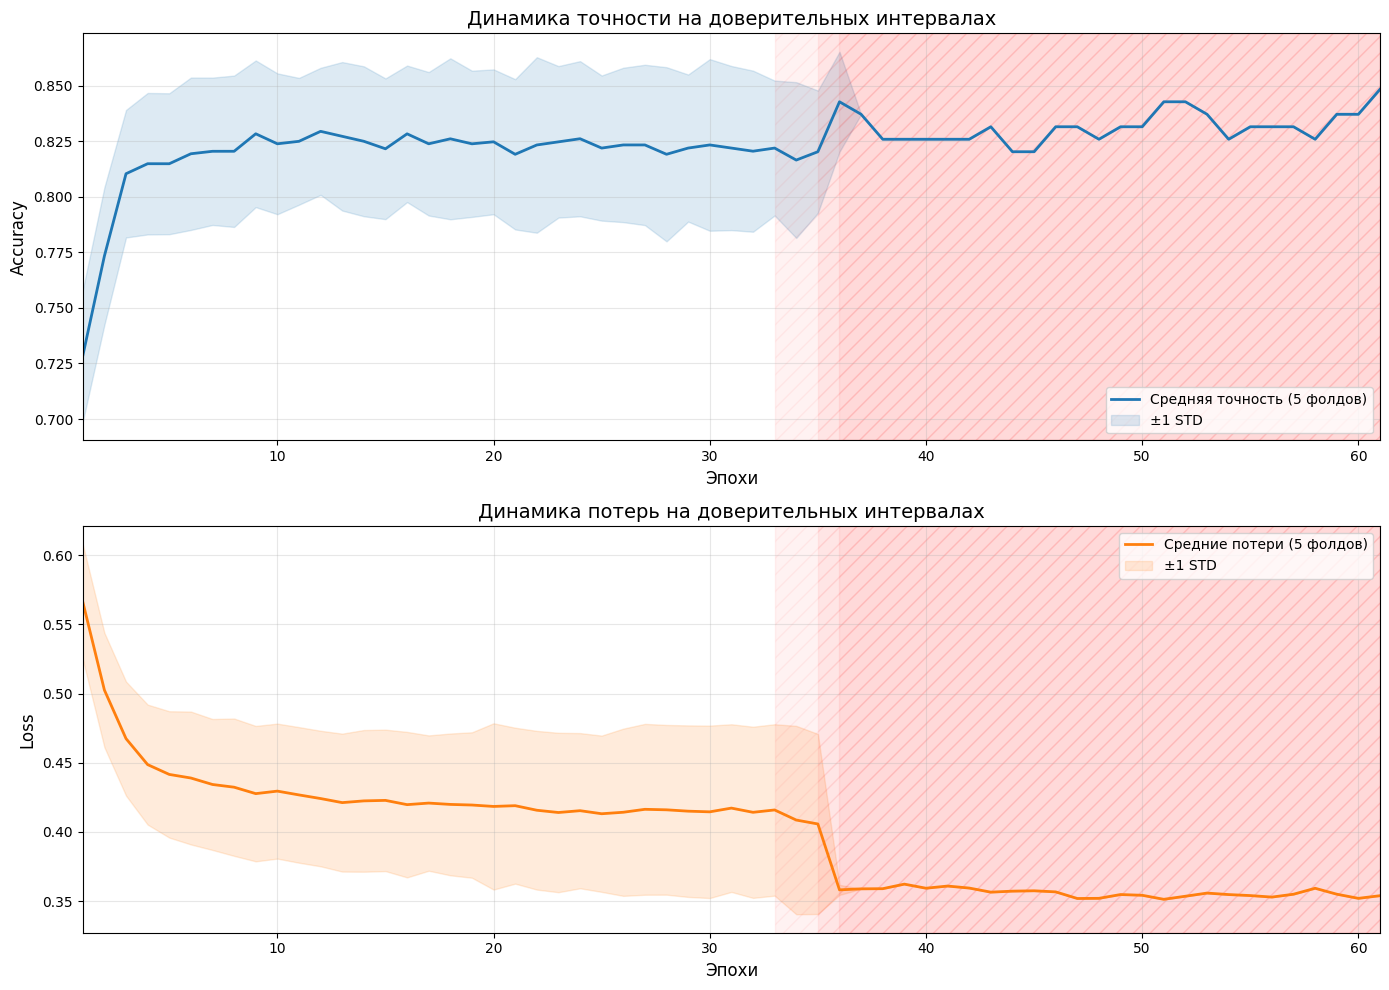

Статистика по эпохам:
Эпоха 1: 5 фолдов, Accuracy = 0.7284 ± 0.0296, Loss = 0.5662 ± 0.0415
Эпоха 6: 5 фолдов, Accuracy = 0.8193 ± 0.0343, Loss = 0.4390 ± 0.0480
Эпоха 11: 5 фолдов, Accuracy = 0.8249 ± 0.0285, Loss = 0.4268 ± 0.0490
Эпоха 16: 5 фолдов, Accuracy = 0.8283 ± 0.0307, Loss = 0.4197 ± 0.0525
Эпоха 21: 4 фолдов, Accuracy = 0.8191 ± 0.0338, Loss = 0.4190 ± 0.0563
Эпоха 26: 4 фолдов, Accuracy = 0.8233 ± 0.0347, Loss = 0.4143 ± 0.0604
Эпоха 31: 4 фолдов, Accuracy = 0.8219 ± 0.0369, Loss = 0.4173 ± 0.0605
Эпоха 36: 2 фолдов, Accuracy = 0.8427 ± 0.0225, Loss = 0.3582 ± 0.0037
Эпоха 41: 1 фолдов, Accuracy = 0.8258 ± 0.0000, Loss = 0.3610 ± 0.0000
Эпоха 46: 1 фолдов, Accuracy = 0.8315 ± 0.0000, Loss = 0.3567 ± 0.0000
Эпоха 51: 1 фолдов, Accuracy = 0.8427 ± 0.0000, Loss = 0.3514 ± 0.0000
Эпоха 56: 1 фолдов, Accuracy = 0.8315 ± 0.0000, Loss = 0.3530 ± 0.0000
Эпоха 61: 1 фолдов, Accuracy = 0.8483 ± 0.0000, Loss = 0.3540 ± 0.0000


In [21]:
# Определяем максимальное количество эпох среди всех фолдов
max_epochs = max(len(acc) for acc in val_accuracies)

# Создаем массивы для усредненных значений
mean_accuracy = np.zeros(max_epochs)
std_accuracy = np.zeros(max_epochs)
count_accuracy = np.zeros(max_epochs)

mean_loss = np.zeros(max_epochs)
std_loss = np.zeros(max_epochs)
count_loss = np.zeros(max_epochs)

# Заполняем массивы, учитывая только существующие значения
for epoch in range(max_epochs):
    epoch_accuracies = []
    epoch_losses = []

    for fold_acc, fold_loss in zip(val_accuracies, val_losses):
        if epoch < len(fold_acc):
            epoch_accuracies.append(fold_acc[epoch])
            epoch_losses.append(fold_loss[epoch])

    if epoch_accuracies:
        mean_accuracy[epoch] = np.mean(epoch_accuracies)
        std_accuracy[epoch] = np.std(epoch_accuracies)
        count_accuracy[epoch] = len(epoch_accuracies)

        mean_loss[epoch] = np.mean(epoch_losses)
        std_loss[epoch] = np.std(epoch_losses)
        count_loss[epoch] = len(epoch_losses)

# Создаем график
plt.figure(figsize=(14, 10))

# График точности
plt.subplot(2, 1, 1)
epochs = range(1, max_epochs+1)

# Основная линия (средняя точность)
plt.plot(epochs, mean_accuracy, '#1f77b4', linewidth=2,
         label=f'Средняя точность ({int(count_accuracy[0])} фолдов)')

# Доверительный интервал
plt.fill_between(epochs,
                 mean_accuracy - std_accuracy,
                 mean_accuracy + std_accuracy,
                 color='#1f77b4', alpha=0.15, label='±1 STD')

# Область с уменьшающимся количеством фолдов
for i in range(5, 0, -1):
    if i < count_accuracy[0]:
        idx = np.where(count_accuracy < i)[0]
        if len(idx) > 0:
            start_epoch = idx[0]
            plt.axvspan(start_epoch, max_epochs, alpha=0.05,
                        color='red', hatch='//',
                        label=f'Только {i} фолдов' if i==5 else "")

plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Динамика точности на доверительных интервалах', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.xlim(1, max_epochs)

# График потерь
plt.subplot(2, 1, 2)
plt.plot(epochs, mean_loss, '#ff7f0e', linewidth=2,
         label=f'Средние потери ({int(count_loss[0])} фолдов)')

plt.fill_between(epochs,
                 mean_loss - std_loss,
                 mean_loss + std_loss,
                 color='#ff7f0e', alpha=0.15, label='±1 STD')

for i in range(5, 0, -1):
    if i < count_loss[0]:
        idx = np.where(count_loss < i)[0]
        if len(idx) > 0:
            start_epoch = idx[0]
            plt.axvspan(start_epoch, max_epochs, alpha=0.05,
                        color='red', hatch='//',
                        label=f'Только {i} фолдов' if i==5 else "")

plt.xlabel('Эпохи', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Динамика потерь на доверительных интервалах', fontsize=14)
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.xlim(1, max_epochs)

plt.tight_layout()
plt.show()

# Вывод информации о количестве фолдов
print("Статистика по эпохам:")
for epoch in range(0, max_epochs, 5):  # Каждую 5-ю эпоху
    print(f"Эпоха {epoch+1}: {int(count_accuracy[epoch])} фолдов, "
          f"Accuracy = {mean_accuracy[epoch]:.4f} ± {std_accuracy[epoch]:.4f}, "
          f"Loss = {mean_loss[epoch]:.4f} ± {std_loss[epoch]:.4f}")

### Выводы

График точности:

- Кривая возрастает примерно до 10-й эпохи, модель эффективно обучается, а далее начинает варьироваться около 0.8.

- Узкая доверительная область говорит об стабильности на всех фолдах.

- В некоторый момент доверительная область пропадает из-за ранней остановки, которая сработала во многих фолдах, но был фолд, который продолжал работу.

График потерь:

- Резкое падение в первых 10 эпохах говорит о быстрой сходимости.

- Так как кривая падает, то ошибки снижаются.

- Закрашенная область сужается с увелечением эпохи, что говорит о минимальном риске переобучения.

- В некоторый момент доверительная область пропадает из-за ранней остановки, которая сработала во многих фолдах, но был фолд, который продолжал работу.

## Графики для тренировочных и валидационных данных

На графике можно увидеть следующее:

1. Зеленая/оранжевая линии — метрики на данных из тренировочных выборок.

2. Синяя/красная линии — метрики на данных из тестовых выборок.

Если графики будут сильно расходится, то это значит, что модель переобучается (например, точность на тренировке растет, а на валидации падает).

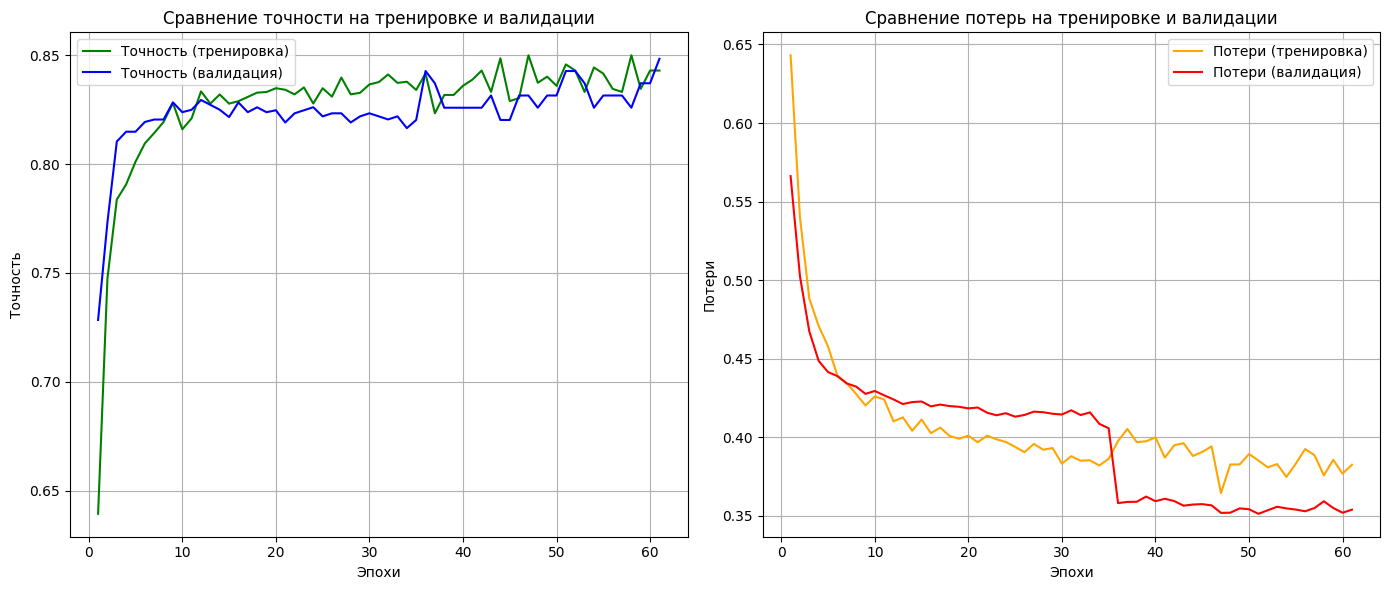

In [23]:
# Обработка тренировочных метрик
mean_train_accuracy = np.zeros(max_epochs)
mean_train_loss = np.zeros(max_epochs)

for epoch in range(max_epochs):
    epoch_train_accuracies = []
    epoch_train_losses = []

    for fold_acc, fold_loss in zip(train_accuracies, train_losses):
        if epoch < len(fold_acc):
            epoch_train_accuracies.append(fold_acc[epoch])
            epoch_train_losses.append(fold_loss[epoch])

    mean_train_accuracy[epoch] = np.mean(epoch_train_accuracies)
    mean_train_loss[epoch] = np.mean(epoch_train_losses)

# Удаляем старые строки с np.mean(all_train_accuracies, axis=0) и np.mean(all_train_losses, axis=0)
# И используем подготовленные массивы mean_train_accuracy и mean_train_loss

# Построение графиков (переписанная часть)
plt.figure(figsize=(14, 6))

# График точности
plt.subplot(1, 2, 1)
plt.plot(epochs, mean_train_accuracy, 'g-', label='Точность (тренировка)')
plt.plot(epochs, mean_accuracy, 'b-', label='Точность (валидация)')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.title('Сравнение точности на тренировке и валидации')
plt.legend()
plt.grid(True)

# График потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, mean_train_loss, 'orange', label='Потери (тренировка)')
plt.plot(epochs, mean_loss, 'r-', label='Потери (валидация)')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.title('Сравнение потерь на тренировке и валидации')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Вывод

График точности:

- Точность на тренировочных данных (зеленая линия) стабильно растет в первые 10 эпох, а затем начинает варьироваться около значения 0.825.

- Точность на валидационных данных (синяя линия) демонстрирует схожий рост, но стабилизируется на определенном уровне (0.825 примерно).

- Кривые тренировочной и валидационной точности идут близко друг к другу без значительного расхождения.

График потерь:

- Потери на тренировке (оранжевая линия) последовательно уменьшаются по мере обучения.

- Потери на валидации (красная линия) снижаются синхронно с тренировочными, с 30 по 40 эпоху переживают резкий спад, но после стабилизируются.

- Обе кривые сохраняют близкую траекторию на протяжении всего обучения.

## Вывод матрицы ошибок для каждого фолда

Матрица ошибок демонстрирует, сколько раз модель правильно и неправильно классифицировала значение по классу.

Выведем для каждого фолда эту матрицу:

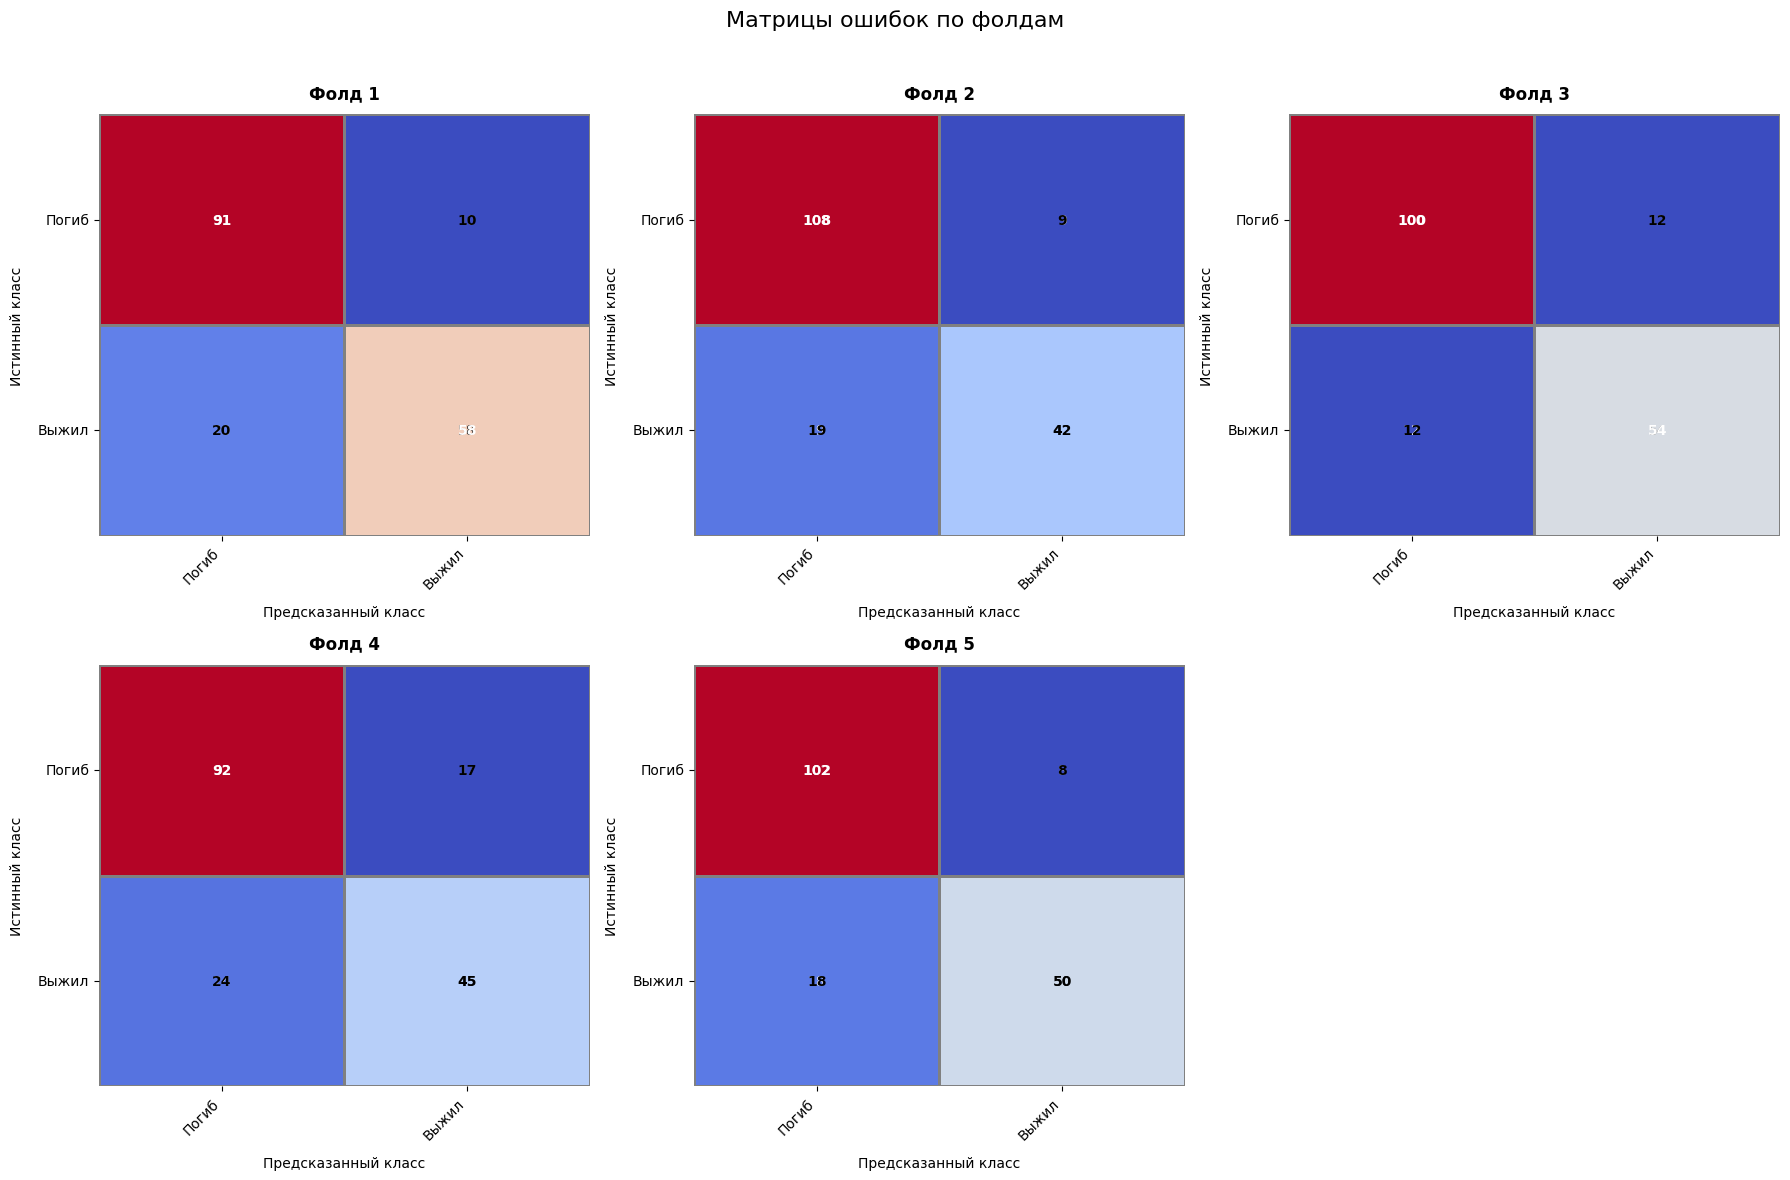

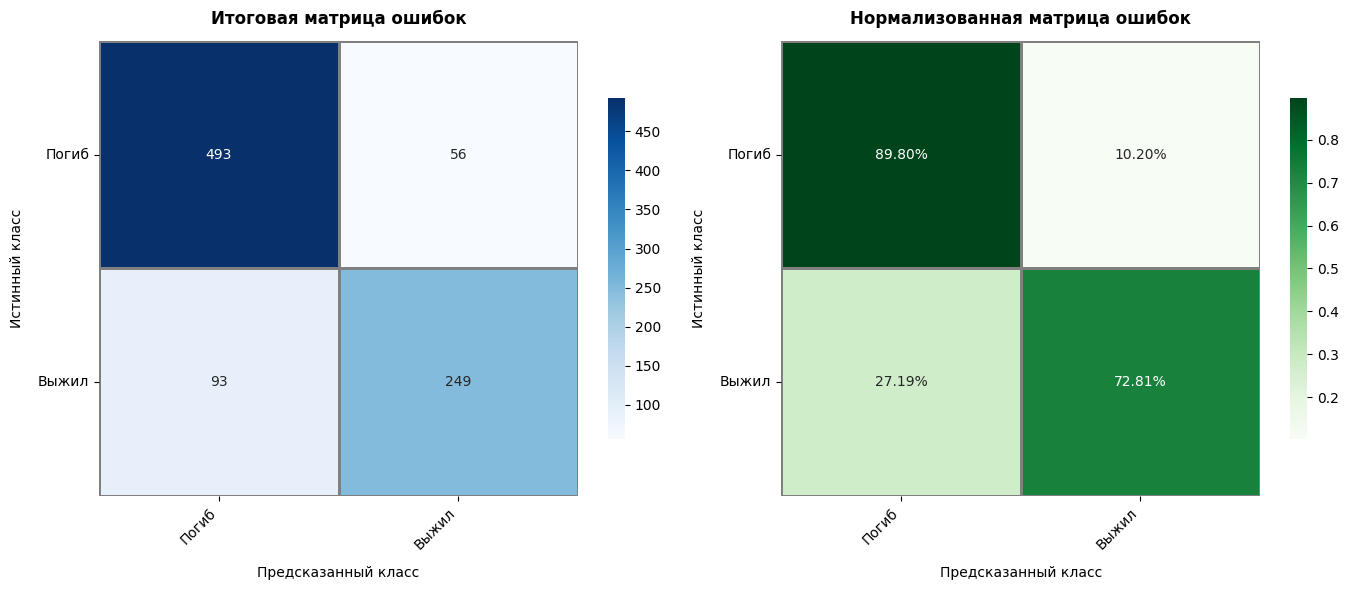

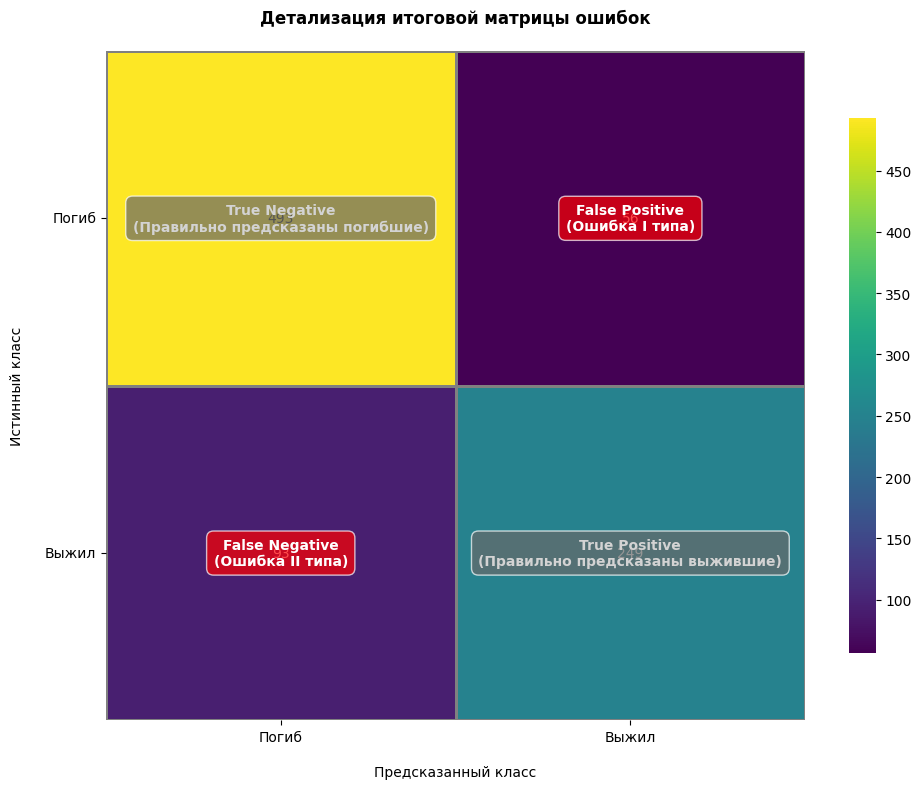

In [24]:
# Настройка стиля
sns.set_palette('Set2')
plt.rcParams['font.family'] = 'DejaVu Sans'

# 1. Матрицы ошибок для каждого фолда
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Матрицы ошибок по фолдам', fontsize=16)

for i, cm in enumerate(all_conf_matrices):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    # Создаем тепловую карту
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
                cbar=False, linewidths=1, linecolor='gray',
                ax=ax)

    # Настройка аннотаций
    ax.set_title(f'Фолд {i+1}', fontweight='bold', pad=12)
    ax.set_xlabel('Предсказанный класс', labelpad=10)
    ax.set_ylabel('Истинный класс', labelpad=10)
    ax.xaxis.set_ticklabels(target_names, rotation=45, ha='right')
    ax.yaxis.set_ticklabels(target_names, rotation=0)

    # Добавляем фоновые подписи
    for j in range(len(target_names)):
        for k in range(len(target_names)):
            text_color = 'white' if cm[j, k] > cm.max()/2 else 'black'
            ax.text(k+0.5, j+0.5, str(cm[j, k]),
                    ha='center', va='center',
                    color=text_color, fontweight='bold')

# Скрываем пустые подграфики
for i in range(len(all_conf_matrices), 6):
    axes.flatten()[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 2. Итоговая матрица ошибок
total_confusion_matrix = np.sum(all_conf_matrices, axis=0)
normalized_total = total_confusion_matrix.astype('float') / total_confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 6))

# Не нормализованная
plt.subplot(1, 2, 1)
sns.heatmap(total_confusion_matrix, annot=True, fmt='d', cmap='Blues',
           cbar_kws={'shrink': 0.75}, linewidths=1, linecolor='gray')
plt.title('Итоговая матрица ошибок', fontweight='bold', pad=12)
plt.xlabel('Предсказанный класс', labelpad=10)
plt.ylabel('Истинный класс', labelpad=10)
plt.xticks(ticks=[0.5, 1.5], labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=[0.5, 1.5], labels=target_names, rotation=0)

# Нормализованная
plt.subplot(1, 2, 2)
sns.heatmap(normalized_total, annot=True, fmt='.2%', cmap='Greens',
           cbar_kws={'shrink': 0.75}, linewidths=1, linecolor='gray')
plt.title('Нормализованная матрица ошибок', fontweight='bold', pad=12)
plt.xlabel('Предсказанный класс', labelpad=10)
plt.ylabel('Истинный класс', labelpad=10)
plt.xticks(ticks=[0.5, 1.5], labels=target_names, rotation=45, ha='right')
plt.yticks(ticks=[0.5, 1.5], labels=target_names, rotation=0)

plt.tight_layout()
plt.show()

# 3. Детализация итоговой матрицы
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(total_confusion_matrix, annot=True, fmt='d', cmap='viridis',
           cbar_kws={'shrink': 0.8}, linewidths=1, linecolor='gray',
           ax=ax)

# Добавляем поясняющие подписи
annotations = [
    f"True Negative\n(Правильно предсказаны погибшие)",
    f"False Positive\n(Ошибка I типа)",
    f"False Negative\n(Ошибка II типа)",
    f"True Positive\n(Правильно предсказаны выжившие)"
]

for i, text in enumerate(annotations):
    row, col = i // 2, i % 2
    ax.text(col + 0.5, row + 0.5, text,
            ha='center', va='center',
            color='w' if i in [1,2] else 'lightgray',
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5',
                      fc=('red' if i in [1,2] else 'dimgray'),
                      ec='white', alpha=0.7))

plt.title('Детализация итоговой матрицы ошибок', fontweight='bold', pad=20)
plt.xlabel('Предсказанный класс', labelpad=15)
plt.ylabel('Истинный класс', labelpad=15)
plt.xticks(ticks=[0.5, 1.5], labels=target_names, rotation=0)
plt.yticks(ticks=[0.5, 1.5], labels=target_names, rotation=0)
plt.tight_layout()
plt.show()

In [26]:
for i, (report, cm) in enumerate(zip(all_reports, all_conf_matrices)):
    print(f"\nФолд {i+1}:\n")
    print("Отчет о классификации:")
    print(report)


Фолд 1:

Отчет о классификации:
              precision    recall  f1-score   support

       Погиб       0.82      0.90      0.86       101
       Выжил       0.85      0.74      0.79        78

    accuracy                           0.83       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.83      0.83      0.83       179


Фолд 2:

Отчет о классификации:
              precision    recall  f1-score   support

       Погиб       0.85      0.92      0.89       117
       Выжил       0.82      0.69      0.75        61

    accuracy                           0.84       178
   macro avg       0.84      0.81      0.82       178
weighted avg       0.84      0.84      0.84       178


Фолд 3:

Отчет о классификации:
              precision    recall  f1-score   support

       Погиб       0.89      0.89      0.89       112
       Выжил       0.82      0.82      0.82        66

    accuracy                           0.87       178
   macro avg       0.86      

Для класса "Погибшие":

- Точность (precision): 79-89% объектов, предсказанных как погибшие, действительно принадлежат этому классу. Это свидетельствует о высоком качестве положительных прогнозов.

- Полнота (recall): Модель корректно идентифицирует 84-93% всех реальных случаев гибели, демонстрируя эффективное распознавание данного класса.

Для класса "Выжившие":

- Точность (precision): Среди всех объектов, отнесённых к выжившим, 73-86% действительно принадлежат этому классу.

- Полнота (recall): Модель выявляет лишь 65-82% реально выживших, что указывает на существенную недооценку этого класса и пропуск значительного числа положительных случаев.

Общая эффективность модели:

- Accuracy: 77-87% всех прогнозов являются верными, отражая стабильную, но не максимальную общую точность классификации.

- Сбалансированность: Значительный разрыв в полноте между классами (84-93% для погибших и 65-82% для выживших) выявляет систематическую проблему с распознаванием выживших.

Неравномерное распределение F1-меры между классами (особенно отличается 4 фолд) указывает на необходимость:

- Коррекции весов классов.

- Применения техник работы с дисбалансом.

- Целевой оптимизации для улучшения распознавания выживших.

- Дополнительной проверки характеристик объектов, связанных с этим классом.

Итоговая матрица ошибок по всем фолдам:

1. Модель верно предсказала смерть **493** пассажиров.
2. Ошибочно предсказала выживание **56** погибшим.
3. Пропустила **93** реальных выживших.
4. Верно предсказала выживание **249** пассажирам.

# Заключение

Проведённый анализ работы нейронной сети для предсказания выживаемости на Титанике позволяет сделать следующие ключевые наблюдения:

1. Ограничения данных
 - Нейросеть показала стабильную работу, но её преимущества не реализуются в полной мере из-за ограниченного объёма данных. Для задач такого масштаба сложные архитектуры становятся избыточными.

2. Сравнительная эффективность

- Классические алгоритмы, такие как "Random Forest" или "XGBoost", могут продемонстрировать большую эффективность на малых данных.

- Традиционные методы дают лучшую точность при меньших вычислительных затратах.

- Оптимизация гиперпараметров для ML-моделей даёт более значимый прирост качества.

3. Дисбаланс в предсказании классов:

- Высокая точность распознавания погибших (Recall: 84-93%).

- Значительное недоопределение выживших (Recall: 65-82%), что может указывать на систематическое смещение модели.

Нейронная сеть показала себя как работоспособное, но не оптимальное решение для данной задачи. Модель требует фундаментальной доработки в части работы с дисбалансом классов, возможно придётся добавить более информативные признаки, перенастроить раннюю остановку модели, убрать скрытый слой и упростить архитектуру нейросети. Тем не менее, для достижения максимальной эффективности рекомендуется смещение фокуса на классические ML-методы с параллельным улучшением качества данных.